In [2]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator

# 1. Define H₂ molecule
driver = PySCFDriver(atom="H 0 0 0; H 0 0 0.735", basis="sto3g")
molecule = driver.run()

# 2. Setup electronic structure problem
problem = molecule.to_problem()

# 3. Mapper
mapper = ParityMapper()

# 4. Classical exact solver (reference)
numpy_solver = NumPyMinimumEigensolverFactory()
calc_exact = GroundStateEigensolver(mapper, numpy_solver)
exact_result = calc_exact.solve(problem)

print("=== Reference Exact Solver ===")
print("Ground state energy (Exact):", exact_result.total_energies[0].real, "Hartree")

# 5. VQE setup
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz", reps=2)
optimizer = SLSQP(maxiter=200)
vqe_solver = VQE(ansatz=ansatz, optimizer=optimizer, estimator=Estimator())

calc_vqe = GroundStateEigensolver(mapper, vqe_solver)
vqe_result = calc_vqe.solve(problem)

print("\n=== VQE Result ===")
print("Ground state energy (VQE):", vqe_result.total_energies[0].real, "Hartree")


AttributeError: 'ElectronicStructureProblem' object has no attribute 'to_problem'

In [9]:
import numpy as np
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.mappers import ParityMapper

# 1. Build molecule
driver = PySCFDriver(atom="H 0 0 0; H 0 0 0.735", basis="sto3g")
problem: ElectronicStructureProblem = driver.run()

# 2. Mapper + qubit operator
mapper = ParityMapper()
hamiltonian, _ = problem.second_q_ops()
qubit_op = mapper.map(hamiltonian)

# 3. Convert to dense matrix & solve
dense_matrix = qubit_op.to_matrix()
eigvals, eigvecs = np.linalg.eigh(dense_matrix)

print("=== Reference Exact Solver (manual) ===")
print("Ground state energy (Exact):", eigvals[0].real, "Hartree")


=== Reference Exact Solver (manual) ===
Ground state energy (Exact): -1.8572750302023802 Hartree


In [10]:
import numpy as np
from qiskit.algorithms.optimizers import SLSQP
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit.algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator

# 1. Define molecule (H2)
driver = PySCFDriver(atom="H 0 0 0; H 0 0 0.735", basis="sto3g")
problem = driver.run()

# 2. Get Hamiltonian
hamiltonian, _ = problem.second_q_ops()
mapper = ParityMapper()
qubit_op = mapper.map(hamiltonian)

# === Exact Solver (manual, reference) ===
dense_matrix = qubit_op.to_matrix()
eigvals, eigvecs = np.linalg.eigh(dense_matrix)
exact_energy = eigvals[0].real
print("=== Reference Exact Solver (manual) ===")
print("Ground state energy (Exact):", exact_energy, "Hartree")

# === VQE Solver ===
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz", reps=2)
optimizer = SLSQP(maxiter=200)
vqe_solver = VQE(ansatz=ansatz, optimizer=optimizer, estimator=Estimator())

calc_vqe = GroundStateEigensolver(mapper, vqe_solver)
vqe_result = calc_vqe.solve(problem)

print("\n=== VQE Solver ===")
print("Ground state energy (VQE):", vqe_result.total_energies[0].real, "Hartree")


=== Reference Exact Solver (manual) ===
Ground state energy (Exact): -1.8572750302023802 Hartree

=== VQE Solver ===
Ground state energy (VQE): -1.1170000662524164 Hartree


=== Improved VQE ===
Ground state energy (VQE): -1.1169924383491225 Hartree


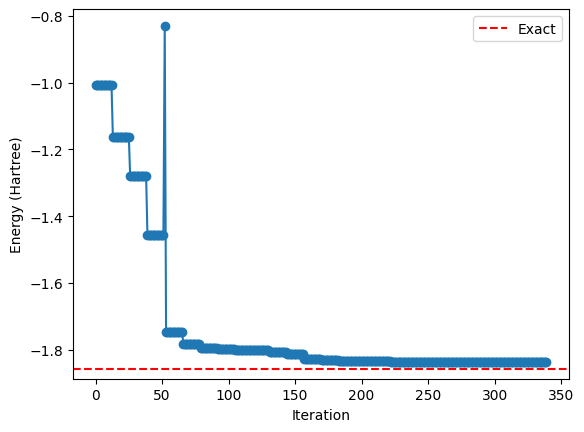

In [11]:
from qiskit.algorithms.minimum_eigensolvers import VQE
import matplotlib.pyplot as plt

energies = []

def callback(eval_count, params, energy, metadata):
    energies.append(energy)

vqe_solver = VQE(ansatz=ansatz, optimizer=optimizer, estimator=Estimator(), callback=callback)

calc_vqe = GroundStateEigensolver(mapper, vqe_solver)
vqe_result = calc_vqe.solve(problem)

print("=== Improved VQE ===")
print("Ground state energy (VQE):", vqe_result.total_energies[0].real, "Hartree")

# Plot convergence
plt.plot(energies, marker="o")
plt.axhline(y=exact_energy, color="r", linestyle="--", label="Exact")
plt.xlabel("Iteration")
plt.ylabel("Energy (Hartree)")
plt.legend()
plt.show()


=== Improved VQE ===
Ground state energy (Exact): -1.857275 Hartree
Ground state energy (VQE):   -1.137215 Hartree


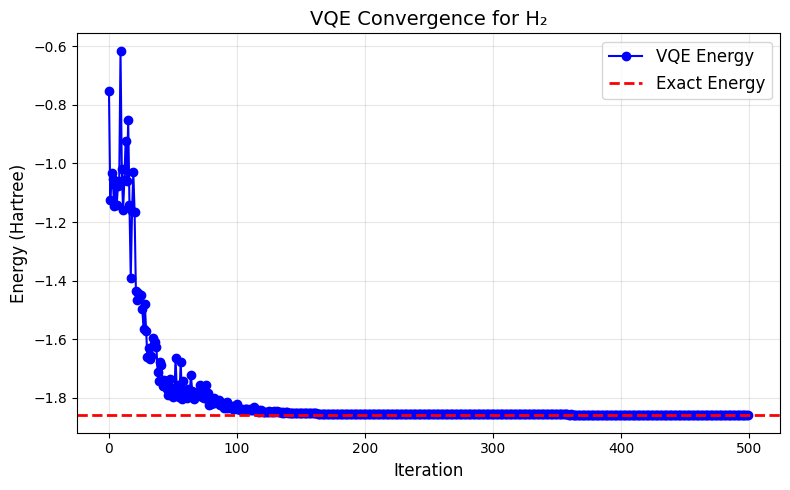

In [12]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA
import matplotlib.pyplot as plt

# Track energies per iteration
energies = []

def callback(eval_count, params, energy, metadata):
    energies.append(energy)

# Use deeper ansatz + better optimizer
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz", reps=4)
optimizer = COBYLA(maxiter=500)

vqe_solver = VQE(ansatz=ansatz, optimizer=optimizer, estimator=Estimator(), callback=callback)
calc_vqe = GroundStateEigensolver(mapper, vqe_solver)
vqe_result = calc_vqe.solve(problem)

vqe_energy = vqe_result.total_energies[0].real

print("=== Improved VQE ===")
print(f"Ground state energy (Exact): {exact_energy:.6f} Hartree")
print(f"Ground state energy (VQE):   {vqe_energy:.6f} Hartree")

# ---- PLOT ----
plt.figure(figsize=(8,5))
plt.plot(energies, marker="o", linestyle="-", color="blue", label="VQE Energy")
plt.axhline(y=exact_energy, color="red", linestyle="--", linewidth=2, label="Exact Energy")

plt.title("VQE Convergence for H₂", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Energy (Hartree)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [18]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.converters import QubitConverter
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator
import matplotlib.pyplot as plt

# ---- 1. Use PySCFDriver (second_q) directly ----
driver = PySCFDriver(
    atom="Li 0 0 0; H 0 0 1.6",
    unit="Angstrom",
    basis="sto3g"
)

problem = driver.run()  # returns ElectronicStructureDriverResult

# ---- 2. Mapper / Qubit Converter ----
mapper = ParityMapper()
qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)

# ---- 3. Exact Solver ----
numpy_solver = NumPyMinimumEigensolver()
calc_exact = GroundStateEigensolver(qubit_converter, numpy_solver)
exact_result = calc_exact.solve(problem)
exact_energy = exact_result.total_energies[0].real

# ---- 4. VQE Solver ----
energies = []
def callback(eval_count, params, energy, metadata):
    energies.append(energy)

ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz", reps=2)
optimizer = COBYLA(maxiter=300)

vqe_solver = VQE(ansatz=ansatz, optimizer=optimizer, estimator=Estimator(), callback=callback)
calc_vqe = GroundStateEigensolver(qubit_converter, vqe_solver)
vqe_result = calc_vqe.solve(problem)
vqe_energy = vqe_result.total_energies[0].real

# ---- 5. Print results ----
print("=== LiH Results ===")
print(f"Ground state energy (Exact): {exact_energy:.6f} Hartree")
print(f"Ground state energy (VQE):   {vqe_energy:.6f} Hartree")

# ---- 6. Plot convergence ----
plt.figure(figsize=(8,5))
plt.plot(energies, marker="o", linestyle="-", color="blue", label="VQE Energy")
plt.axhline(y=exact_energy, color="red", linestyle="--", linewidth=2, label="Exact Energy")
plt.title("VQE Convergence for LiH", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Energy (Hartree)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'qiskit_nature.second_q.converters'

In [20]:
# === LiH Ground State Energy Calculation (QBraid Compatible) ===

from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator
import numpy as np
import matplotlib.pyplot as plt

# ---- 1. Define LiH molecule ----
driver = PySCFDriver(
    atom="Li 0 0 0; H 0 0 1.6",
    unit=UnitsType.ANGSTROM,
    basis="sto3g"
)
problem = ElectronicStructureProblem(driver)

# ---- 2. Mapper / Qubit Converter ----
mapper = ParityMapper()
qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)

# ---- 3. Exact Solver (dense matrix) ----
# Convert operator to dense to avoid sparse .H issue
main_operator, aux_ops = qubit_converter.convert(problem.second_q_ops()[0], num_particles=problem.num_particles)
main_operator_dense = main_operator.to_matrix()  # dense matrix

eigvals, eigvecs = np.linalg.eigh(main_operator_dense)
exact_energy = eigvals[0].real
print("=== LiH Results ===")
print(f"Ground state energy (Exact, dense): {exact_energy:.6f} Hartree")

# ---- 4. VQE Solver ----
energies = []

def callback(eval_count, params, energy, metadata):
    energies.append(energy)

ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz", reps=2)
optimizer = COBYLA(maxiter=300)

vqe_solver = VQE(ansatz=ansatz, optimizer=optimizer, estimator=Estimator(), callback=callback)
vqe_result = vqe_solver.compute_minimum_eigenvalue(main_operator)
vqe_energy = vqe_result.eigenvalue.real

print(f"Ground state energy (VQE): {vqe_energy:.6f} Hartree")

# ---- 5. Plot VQE Convergence ----
plt.figure(figsize=(8,5))
plt.plot(energies, marker="o", linestyle="-", color="blue", label="VQE Energy")
plt.axhline(y=exact_energy, color="red", linestyle="--", linewidth=2, label="Exact Energy")
plt.title("VQE Convergence for LiH", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Energy (Hartree)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


KeyError: 0

In [21]:
# === LiH Ground State Energy Calculation (QBraid Compatible) ===

from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator
import numpy as np
import matplotlib.pyplot as plt

# ---- 1. Define LiH molecule ----
driver = PySCFDriver(
    atom="Li 0 0 0; H 0 0 1.6",
    unit=UnitsType.ANGSTROM,
    basis="sto3g"
)
problem = ElectronicStructureProblem(driver)

# ---- 2. Mapper / Qubit Converter ----
mapper = ParityMapper()
qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)

# ---- 3. Exact Solver (dense matrix) ----
# Convert operator to dense to avoid sparse .H issue
main_operator, aux_ops = qubit_converter.convert(problem.second_q_ops()[0], num_particles=problem.num_particles)
main_operator_dense = main_operator.to_matrix()  # dense matrix

eigvals, eigvecs = np.linalg.eigh(main_operator_dense)
exact_energy = eigvals[0].real
print("=== LiH Results ===")
print(f"Ground state energy (Exact, dense): {exact_energy:.6f} Hartree")

# ---- 4. VQE Solver ----
energies = []

def callback(eval_count, params, energy, metadata):
    energies.append(energy)

ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz", reps=2)
optimizer = COBYLA(maxiter=300)

vqe_solver = VQE(ansatz=ansatz, optimizer=optimizer, estimator=Estimator(), callback=callback)
vqe_result = vqe_solver.compute_minimum_eigenvalue(main_operator)
vqe_energy = vqe_result.eigenvalue.real

print(f"Ground state energy (VQE): {vqe_energy:.6f} Hartree")

# ---- 5. Plot VQE Convergence ----
plt.figure(figsize=(8,5))
plt.plot(energies, marker="o", linestyle="-", color="blue", label="VQE Energy")
plt.axhline(y=exact_energy, color="red", linestyle="--", linewidth=2, label="Exact Energy")
plt.title("VQE Convergence for LiH", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Energy (Hartree)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


KeyError: 0

Available operators: dict_keys(['ParticleNumber', 'ElectronicEnergy', 'DipoleMomentX', 'DipoleMomentY', 'DipoleMomentZ', 'AngularMomentum', 'Magnetization'])
=== LiH Results ===
Ground state energy (Exact, dense): -8.874532 Hartree
Ground state energy (VQE): -8.648358 Hartree


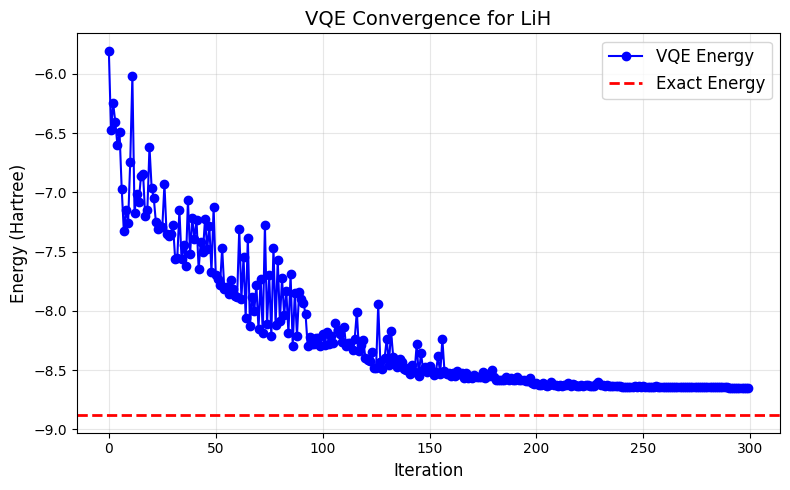

In [22]:
# === LiH Ground State Energy Calculation (QBraid Compatible) ===

from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator
import numpy as np
import matplotlib.pyplot as plt

# ---- 1. Define LiH molecule ----
driver = PySCFDriver(
    atom="Li 0 0 0; H 0 0 1.6",
    unit=UnitsType.ANGSTROM,
    basis="sto3g"
)
problem = ElectronicStructureProblem(driver)

# ---- 2. Mapper / Qubit Converter ----
mapper = ParityMapper()
qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)

# ---- 3. Exact Solver (dense matrix) ----
second_q_ops = problem.second_q_ops()  # returns dict
print("Available operators:", second_q_ops.keys())  # Check the keys

# Usually the main Hamiltonian is under 'ElectronicEnergy'
main_op = second_q_ops['ElectronicEnergy']

# Convert to qubit operator
main_operator = qubit_converter.convert(main_op, num_particles=problem.num_particles)
main_operator_dense = main_operator.to_matrix()  # dense matrix for exact solver

# Compute exact eigenvalues
eigvals, eigvecs = np.linalg.eigh(main_operator_dense)
exact_energy = eigvals[0].real
print("=== LiH Results ===")
print(f"Ground state energy (Exact, dense): {exact_energy:.6f} Hartree")

# ---- 4. VQE Solver ----
energies = []

def callback(eval_count, params, energy, metadata):
    energies.append(energy)

ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz", reps=2)
optimizer = COBYLA(maxiter=300)

vqe_solver = VQE(ansatz=ansatz, optimizer=optimizer, estimator=Estimator(), callback=callback)
vqe_result = vqe_solver.compute_minimum_eigenvalue(main_operator)
vqe_energy = vqe_result.eigenvalue.real

print(f"Ground state energy (VQE): {vqe_energy:.6f} Hartree")

# ---- 5. Plot VQE Convergence ----
plt.figure(figsize=(8,5))
plt.plot(energies, marker="o", linestyle="-", color="blue", label="VQE Energy")
plt.axhline(y=exact_energy, color="red", linestyle="--", linewidth=2, label="Exact Energy")
plt.title("VQE Convergence for LiH", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Energy (Hartree)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



=== H2 ===
Exact ground state energy: -1.852388 Hartree
VQE ground state energy:   -1.852388 Hartree


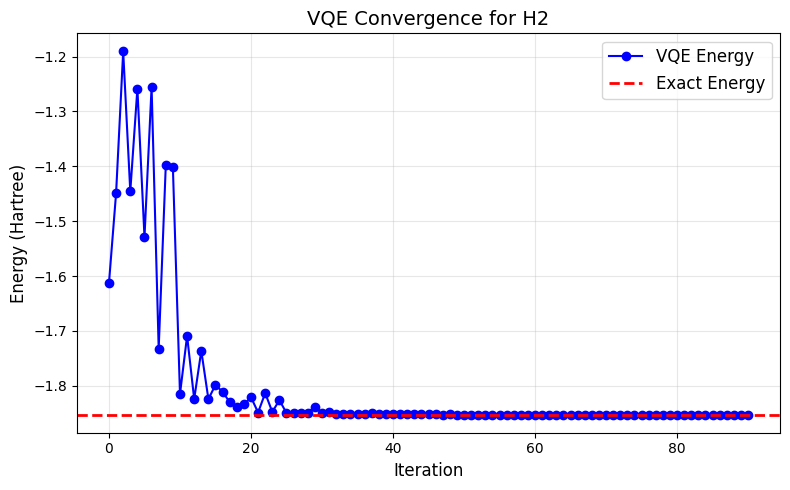


=== LiH ===
Exact ground state energy: -8.874532 Hartree
VQE ground state energy:   -8.799856 Hartree


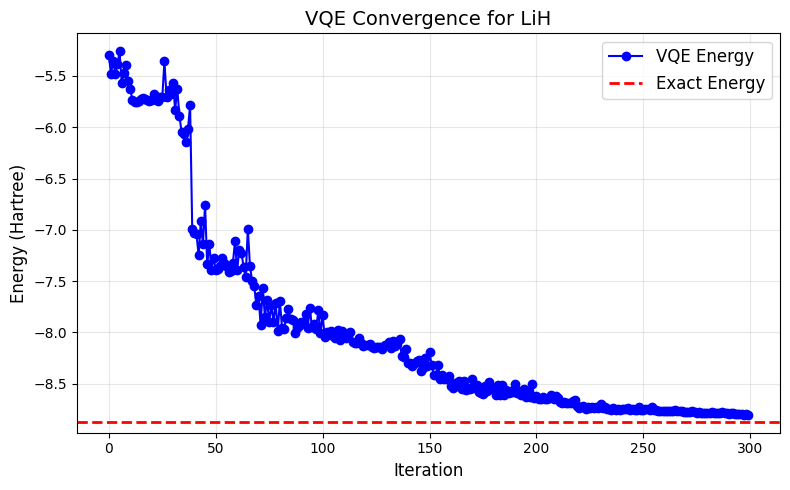

In [23]:
# === Ground State Energy Calculation for H2 and LiH (QBraid Compatible) ===

from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator
import numpy as np
import matplotlib.pyplot as plt

# ---- Function to compute energies ----
def compute_energies(atom_string, molecule_name):
    print(f"\n=== {molecule_name} ===")
    
    # ---- Driver and Problem ----
    driver = PySCFDriver(atom=atom_string, unit=UnitsType.ANGSTROM, basis="sto3g")
    problem = ElectronicStructureProblem(driver)
    
    # ---- Mapper / Qubit Converter ----
    mapper = ParityMapper()
    qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)
    
    # ---- Exact Solver (dense) ----
    second_q_ops = problem.second_q_ops()
    main_op = second_q_ops['ElectronicEnergy']
    main_operator = qubit_converter.convert(main_op, num_particles=problem.num_particles)
    main_operator_dense = main_operator.to_matrix()
    eigvals, eigvecs = np.linalg.eigh(main_operator_dense)
    exact_energy = eigvals[0].real
    print(f"Exact ground state energy: {exact_energy:.6f} Hartree")
    
    # ---- VQE Solver ----
    energies = []
    def callback(eval_count, params, energy, metadata):
        energies.append(energy)
    
    ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz", reps=2)
    optimizer = COBYLA(maxiter=300)
    vqe_solver = VQE(ansatz=ansatz, optimizer=optimizer, estimator=Estimator(), callback=callback)
    vqe_result = vqe_solver.compute_minimum_eigenvalue(main_operator)
    vqe_energy = vqe_result.eigenvalue.real
    print(f"VQE ground state energy:   {vqe_energy:.6f} Hartree")
    
    # ---- Plot Convergence ----
    plt.figure(figsize=(8,5))
    plt.plot(energies, marker="o", linestyle="-", color="blue", label="VQE Energy")
    plt.axhline(y=exact_energy, color="red", linestyle="--", linewidth=2, label="Exact Energy")
    plt.title(f"VQE Convergence for {molecule_name}", fontsize=14)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Energy (Hartree)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ---- H2 Molecule ----
compute_energies("H 0 0 0; H 0 0 0.74", "H2")

# ---- LiH Molecule ----
compute_energies("Li 0 0 0; H 0 0 1.6", "LiH")
